# Manipulating Twitter Data for Analysis
## After Filtering Out the Relevant Tweets, We Will Prepare the Data for a Final Analysis. We Need 3 Variables: 
1. When the Tweet was Created
2. The Full Text of the Tweet
3. Whether the Tweet is Associated with Washington or Florida

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
from pygeocoder import Geocoder
import reverse_geocoder as rg 
import glob
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Combine all csv Files that were Output in the Previous Steps

In [4]:
# Use Glob package to combine all csv files in a directory into one and read them in as a dtaframe
tweets = pd.DataFrame()
for f in glob.glob("C:\\Users\\John\\Desktop\\MSIM\\Spring Quarter 2020\\IMT 575\\Group Project\\twitter data sets\\CsvOutputs\\random*.csv"):
    df = pd.read_csv(f)
    tweets = all_data.append(df, ignore_index=True)

In [5]:
tweets.head()

,created_at,full_text,userid,location,coordinates,retweeted_text
0,Wed Jan 22 05:06:17 +0000 2020,First US case of Wuhan coronavirus confirmed b...,297176227,"Seattle, WA",NaN,NaN
1,Wed Jan 22 14:25:06 +0000 2020,RT @HelenBranswell: .@WHO has issued the first...,59955964,"Spokane, WA",NaN,.@WHO has issued the first of what I hope will...
2,Wed Jan 22 18:39:12 +0000 2020,Though the heads of the CDC and WHO would stro...,299511490,"Seattle, WA",NaN,NaN
3,Wed Jan 22 20:28:16 +0000 2020,⚠️CONTAINING #CORONAVIRUS⚠️ China is taking ac...,16743886,"Tampa, Florida",NaN,NaN
4,Wed Jan 22 22:06:14 +0000 2020,"Once I set an iPhone alarm, I just never chang...",14922679,Seattle,NaN,NaN


In [6]:
tweets.dtypes

created_at        object
full_text         object
userid             int64
location          object
coordinates       object
retweeted_text    object
dtype: object

In [7]:
# Convert Created At to Date Time
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

In [8]:
print("Number of Days Between First and Last Tweets: {}".format(max(tweets['created_at']) - min(tweets['created_at'])))

Number of Days Between First and Last Tweets: 86 days 21:09:32


Text(0.5, 1.0, 'Number of Tweets per Day')

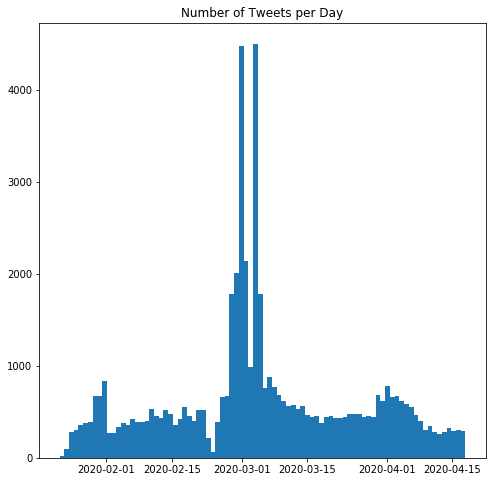

In [46]:
plt.figure(figsize = (8,8))
plt.hist(tweets['created_at'], bins = 86)
plt.title('Number of Tweets per Day')

# Store Locations (Coords & Self-Reported) as Washington or Florida
## We Have Two Columns of Location Data (Coordinates and Location) and We Need Combine the Two into One Final Column

### Determine Tweet Location by User-Defined Location

In [13]:
# Create a new column that will have boolean values if the tweet's user-defiend location is in Washington
tweets['Washington'] = [tweets['location'].str.lower()[i] in ['seattle', 'spokane', 'tacoma', 'bellingham', 'tri cities', 'yakima', 'olympia',
                       'wa', 'washington state', 'seattle, wa', 'spokane, wa', 'tacoma, wa', 'bellingham, wa',
                       'tri cities, wa', 'yakima, wa', 'olympia, wa', 'seattle, washington', 'spokane, washington', 
                       'tacoma, washington', 'bellingham, washington', 'tri cities, washington', 'yakima, washington',
                       'olympia, washington'] for i in range(len(tweets))]

In [14]:
tweets.head()

,created_at,full_text,userid,location,coordinates,retweeted_text,Washington
0,2020-01-22 05:06:17+00:00,First US case of Wuhan coronavirus confirmed b...,297176227,"Seattle, WA",NaN,NaN,True
1,2020-01-22 14:25:06+00:00,RT @HelenBranswell: .@WHO has issued the first...,59955964,"Spokane, WA",NaN,.@WHO has issued the first of what I hope will...,True
2,2020-01-22 18:39:12+00:00,Though the heads of the CDC and WHO would stro...,299511490,"Seattle, WA",NaN,NaN,True
3,2020-01-22 20:28:16+00:00,⚠️CONTAINING #CORONAVIRUS⚠️ China is taking ac...,16743886,"Tampa, Florida",NaN,NaN,False
4,2020-01-22 22:06:14+00:00,"Once I set an iPhone alarm, I just never chang...",14922679,Seattle,NaN,NaN,True


In [15]:
# Show the number of tweeets from Wa and Fl
tweets['Washington'].value_counts()

True     28439
False    25508
Name: Washington, dtype: int64

### Determine Tweet Location by Geo-Coordinates

In [16]:
# Put the non-null coordinates in a dataframe
coordsdf = pd.DataFrame(tweets['coordinates'][pd.notnull(tweets['coordinates'])])

In [25]:
# The Coordinates are brought in as a JSON object
coordsdf

,coordinates
1181,"{'type': 'Point', 'coordinates': [-84.2836, 30..."
2232,"{'type': 'Point', 'coordinates': [-122.3308, 4..."
2636,"{'type': 'Point', 'coordinates': [-80.1341, 25..."
2637,"{'type': 'Point', 'coordinates': [-82.684, 28...."
2638,"{'type': 'Point', 'coordinates': [-80.26295, 2..."
...,...
53942,"{'type': 'Point', 'coordinates': [-80.25343648..."
53943,"{'type': 'Point', 'coordinates': [-81.3775, 28..."
53944,"{'type': 'Point', 'coordinates': [-122.603, 45..."
53945,"{'type': 'Point', 'coordinates': [-122.459, 47..."


In [17]:
# Get the index position where coordinates are not null
c_ind = coordsdf.index
c_ind

Int64Index([ 1181,  2232,  2636,  2637,  2638,  2639,  2640,  2641,  2642,
             2643,
            ...
            53937, 53938, 53939, 53940, 53941, 53942, 53943, 53944, 53945,
            53946],
           dtype='int64', length=147)

In [26]:
# Turn the JSON objects into a dictionary
coordsdict = pd.DataFrame.to_dict(coordsdf)
# Remove characters to have only the coordinates
coordsdict = [coordsdict['coordinates'][i].split(":")[2].replace("}","").replace("[","").replace("]","").replace("'","") for i in c_ind]

In [29]:
# Split coordinates by the comma to get a latitude and longitude
coords = [coordsdict[i].split(',') for i in range(len(coordsdict))]
lat = [float(coords[i][0]) for i in range(len(coords))]
lon = [float(coords[i][1]) for i in range(len(coords))]
# Store the coordinates in a tuple to pass into the function to reverse GeoCode coorindates
tuplecoords = [(float(coords[i][1]), float(coords[i][0])) for i in range(len(coords))]

In [32]:
# Function to Reverse GeoCode the coordinates to see if they are in Washington or Florida
def reverseGeocode(coordinates): 
    result = rg.search(coordinates)
    return result

In [33]:
# Reverse geocode the coordinates to see which state, Washington or Florida, they belong to
result = []
for i in range(len(tuplecoords)):
    result.append(reverseGeocode(tuplecoords[i]))

Loading formatted geocoded file...


In [34]:
# Determine which State the Tweet is associated with
state = []
for i in range(len(result)):
    state.append(result[i][0]['admin1'])

In [35]:
# Create a new column in the dataframe that will eventually store the state
tweets['States_Coordinates'] = 'Empty'

In [62]:
# Add the state of the reverse geo-coded coordinates to the new column
tweets.loc[list(c_ind), 'States_Coordinates'] = state

In [63]:
# Replace any 'empty' value in the States_Coordinates column with the value from the Washington column.
tweets.loc[pd.notnull(tweets['coordinates'])][['States_Coordinates', 'Washington']]

,States_Coordinates,Washington
1181,Florida,False
2232,Washington,True
2636,Florida,False
2637,Florida,False
2638,Florida,False
...,...,...
53942,Florida,False
53943,Florida,False
53944,Washington,False
53945,Washington,True


In [64]:
# If the States_Coordinates is still empty and the Washington value is true, set the States_Coordinates to Washington,
# otherwise set it to Florida
tweets['States_Coordinates'].loc[(tweets.States_Coordinates == 'Empty') & (tweets.Washington == True)] = 'Washington'
tweets['States_Coordinates'].loc[(tweets.States_Coordinates == 'Empty') & (tweets.Washington == False)] = 'Florida'

In [37]:
# As a check, see where all valid tweet geo-coordinates are located
geometry = [Point(xy) for xy in zip(lat,lon)]
geodf = gpd.GeoDataFrame(geometry, columns = ['geometry'])

It looks like only 1 tweet is in Florida, and 0 are in Washington,
so we should only capture one tweet


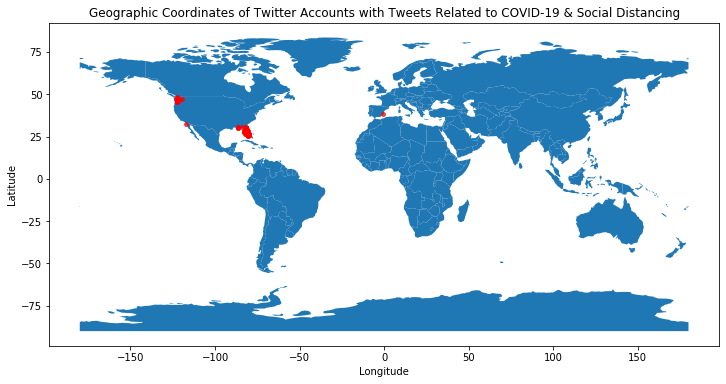

In [38]:
# Plot the points!
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

geodf.plot(ax=world.plot(figsize=(12,12)), marker = 'o', color = 'red', markersize = 15, alpha = .7)  
plt.title('Geographic Coordinates of Twitter Accounts with Tweets Related to COVID-19 & Social Distancing')
plt.ylabel('Latitude')
plt.xlabel('Longitude')


#### Notice two points are not located in Washington or Florida. That is because they had both the geo-coordinates and a user-defined location.

In [29]:
tweets.loc[(tweets.States_Coordinates != 'Florida') & (tweets.States_Coordinates != 'Washington')] 

,Unnamed: 0,created_at,full_text,userid,location,coordinates,retweeted_text,Washington,States_Coordinates
40200,40200,2020-03-16 01:51:26+00:00,"Per usual, I didn't take many pictures at crss...",16347890,"Seattle, WA","{'type': 'Point', 'coordinates': [-117.172056,...",NaN,True,California
42455,42455,2020-03-10 19:20:28+00:00,"coronavirus®️getaway @ Playa Del Postiguet, Al...",40484412,miami,"{'type': 'Point', 'coordinates': [-0.47822772,...",NaN,False,Valencia


In [32]:
# We will use their user-defined location to determine which state they belong to
tweets['States_Coordinates'].loc[tweets.States_Coordinates == 'California'] = 'Washington'
tweets['States_Coordinates'].loc[tweets.States_Coordinates == 'Valencia'] = 'Florida'

In [33]:
tweets.States_Coordinates.value_counts()

Washington    27727
Florida       24710
Name: States_Coordinates, dtype: int64

# Store Longer Tweet (Tweet vs Retweet)

In [57]:
# Create a new column that will store the longer of the two tweets (tweet vs retweet)
tweets['Full Tweet'] = 'Empty'

In [58]:
print("Retweeted Tweet Length: {}\nTweet Length: {}".format(len(tweets['retweeted_text'][1]), len(tweets['full_text'][1])))

Retweeted Tweet Length: 259
Tweet Length: 140


In [59]:
# Find all retweeted tweets and store them in the new column (retweeted are always longer)
tweets['Full Tweet'].loc[pd.notnull(tweets.retweeted_text)] = tweets.retweeted_text

In [60]:
tweets['Full Tweet'].loc[tweets['Full Tweet'] == 'Empty'] = tweets.full_text

In [61]:
tweets.head()

,created_at,full_text,userid,location,coordinates,retweeted_text,Washington,States_Coordinates,Full Tweet
0,2020-01-22 05:06:17+00:00,First US case of Wuhan coronavirus confirmed b...,297176227,"Seattle, WA",NaN,NaN,True,Empty,First US case of Wuhan coronavirus confirmed b...
1,2020-01-22 14:25:06+00:00,RT @HelenBranswell: .@WHO has issued the first...,59955964,"Spokane, WA",NaN,.@WHO has issued the first of what I hope will...,True,Empty,.@WHO has issued the first of what I hope will...
2,2020-01-22 18:39:12+00:00,Though the heads of the CDC and WHO would stro...,299511490,"Seattle, WA",NaN,NaN,True,Empty,Though the heads of the CDC and WHO would stro...
3,2020-01-22 20:28:16+00:00,⚠️CONTAINING #CORONAVIRUS⚠️ China is taking ac...,16743886,"Tampa, Florida",NaN,NaN,False,Empty,⚠️CONTAINING #CORONAVIRUS⚠️ China is taking ac...
4,2020-01-22 22:06:14+00:00,"Once I set an iPhone alarm, I just never chang...",14922679,Seattle,NaN,NaN,True,Empty,"Once I set an iPhone alarm, I just never chang..."


# Select the Variables Needed for Analysis: Tweet Timestamp, Text of Tweet, Location of Tweet and Save to csv for Final Analysis

In [40]:
# Save the dataframe as the final csv file we will use for analysis
tweets[['created_at', 'Full Tweet', 'States_Coordinates']].to_csv("C:\\Users\\John\Desktop\\covid_tweets_fl_wa.csv", encoding = "utf-8", index = False)

<>:1: DeprecationWarning: invalid escape sequence \D
<>:1: DeprecationWarning: invalid escape sequence \D
<>:1: DeprecationWarning: invalid escape sequence \D
<ipython-input-40-a379e7b1ec84>:1: DeprecationWarning: invalid escape sequence \D
  tweets[['created_at', 'Full Tweet', 'States_Coordinates']].to_csv("C:\\Users\\John\Desktop\\covid_tweets_fl_wa.csv", encoding = "utf-8", index = False)
